In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import  precision_score, recall_score, f1_score, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix

In [40]:
sentiment_dataset = pd.read_csv("Sentiment140_filtered.csv")

In [41]:
sentiment_dataset.head()

,Unnamed: 0,target,ids,date,flag,user,text,hate_pred
0,750,0,1467998601,Mon Apr 06 23:11:18 PDT 2009,NO_QUERY,Young_J,I'm off too bed. I gotta wake up hella early t...,1
1,766711,0,2300049112,Tue Jun 23 13:40:12 PDT 2009,NO_QUERY,dougnawoschik,I havent been able to listen to it yet My spe...,1
2,285055,0,1993474319,Mon Jun 01 10:26:09 PDT 2009,NO_QUERY,thireven,now remembers why solving a relatively big equ...,1
3,705995,0,2256551006,Sat Jun 20 12:56:51 PDT 2009,NO_QUERY,taracollins086,"Ate too much, feel sick",1
4,379611,0,2052381070,Sat Jun 06 00:32:23 PDT 2009,NO_QUERY,Portablemonkey,Tried to purchase a parked domain through GoDa...,1


In [42]:
sentiment_dataset.isnull().sum()

Unnamed: 0    0
target        0
ids           0
date          0
flag          0
user          0
text          0
hate_pred     0
dtype: int64

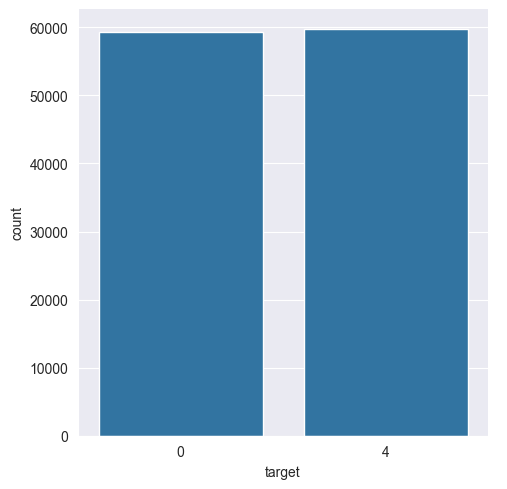

In [43]:
sns.catplot(x = 'target', data = sentiment_dataset, kind = 'count')


In [44]:
hateful_dataset = pd.read_csv("hateful_sentiment.csv")

In [45]:
hateful_dataset.head()

,Content,Label,Content_int
0,retweet to the rejects who constantly call my ...,1,"[146715, 1761, 7, 3, 22587, 67, 6768, 472, 129..."
1,i purpose that whatever attack everyone who ca...,1,"[146715, 80, 4226, 28, 220, 1347, 1568, 67, 65..."
2,are you fucking kidding me you deserve to fuck...,1,"[146715, 154, 26, 69, 1361, 78, 26, 6610, 7, 6..."
3,retweet i am not racist and i am not sexist i ...,1,"[146715, 1761, 80, 81, 76, 1723, 111, 80, 81, ..."
4,just imagine if the two million spent on the s...,1,"[146715, 14, 925, 204, 3, 672, 462, 5271, 9, 3..."


In [46]:
hateful_dataset = hateful_dataset[["Content", "Label"]]
hateful_dataset = hateful_dataset.rename(columns = {"Content": "text", "Label": "target"})
hateful_dataset["target"] = 2

hateful_dataset.head()

,text,target
0,retweet to the rejects who constantly call my ...,2
1,i purpose that whatever attack everyone who ca...,2
2,are you fucking kidding me you deserve to fuck...,2
3,retweet i am not racist and i am not sexist i ...,2
4,just imagine if the two million spent on the s...,2


In [47]:
sentiment_dataset = sentiment_dataset[["text", "target"]]
sentiment_dataset.head()

,text,target
0,I'm off too bed. I gotta wake up hella early t...,0
1,I havent been able to listen to it yet My spe...,0
2,now remembers why solving a relatively big equ...,0
3,"Ate too much, feel sick",0
4,Tried to purchase a parked domain through GoDa...,0


In [48]:
sentiment_dataset.loc[sentiment_dataset['target']==4, 'target'] = 1
sentiment_dataset.loc[sentiment_dataset['target']==0, 'target'] = 0



In [49]:
sentiment_dataset = pd.concat([sentiment_dataset, hateful_dataset], ignore_index= True)

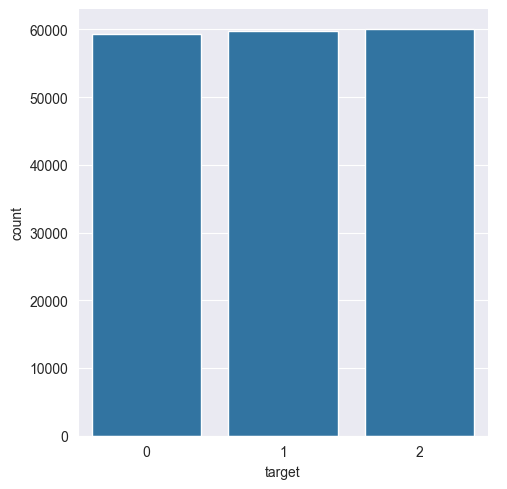

In [50]:
sns.catplot(x = 'target', data = sentiment_dataset, kind = 'count')

In [51]:
sentiment_dataset['target'].value_counts()


target
2    60000
1    59700
0    59300
Name: count, dtype: int64

In [52]:
sentiment_dataset.isnull().sum()

text      0
target    0
dtype: int64

SVM

The only parameter to set in SVM is the type of kernel. We are using the linear one, which is typically chosen for NLP tasks due to the high dimensionality and sparsity of text data.

Fold 1 - Acc: 0.8008 | Prec: 0.8005 | Rec: 0.8004 | F1: 0.8004
Fold 2 - Acc: 0.7980 | Prec: 0.7973 | Rec: 0.7975 | F1: 0.7974
Fold 3 - Acc: 0.7962 | Prec: 0.7957 | Rec: 0.7957 | F1: 0.7956
Fold 4 - Acc: 0.8034 | Prec: 0.8027 | Rec: 0.8030 | F1: 0.8028
Fold 5 - Acc: 0.7973 | Prec: 0.7969 | Rec: 0.7969 | F1: 0.7968

--- Summary ---
Mean Accuracy: 0.7991
Mean Precision: 0.7986
Mean Recall: 0.7987
Mean F1-score: 0.7986


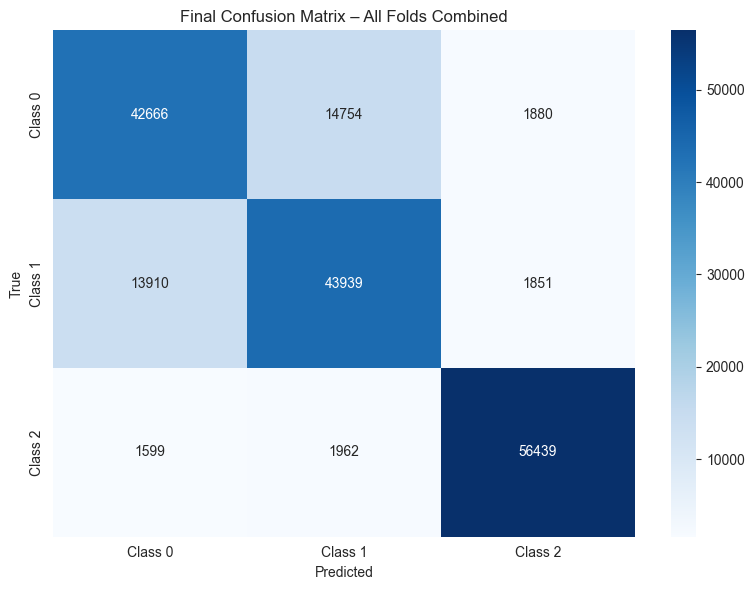

In [53]:
X = sentiment_dataset['text']
y = sentiment_dataset['target']

accuracies = []
precisions = []
recalls = []
f1s = []

y_true_all = []
y_pred_all = []


pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('svc', LinearSVC())
])

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 5-fold stratified cross-validation
for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='macro', zero_division=0)
    rec = recall_score(y_test, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)

    accuracies.append(acc)
    precisions.append(prec)
    recalls.append(rec)
    f1s.append(f1)

    print(f"Fold {fold+1} - Acc: {acc:.4f} | Prec: {prec:.4f} | Rec: {rec:.4f} | F1: {f1:.4f}")
    
    y_true_all.extend(y_test)
    y_pred_all.extend(y_pred)

print("\n--- Summary ---")
print(f"Mean Accuracy: {np.mean(accuracies):.4f}")
print(f"Mean Precision: {np.mean(precisions):.4f}")
print(f"Mean Recall: {np.mean(recalls):.4f}")
print(f"Mean F1-score: {np.mean(f1s):.4f}")

final_cm = confusion_matrix(y_true_all, y_pred_all)

plt.figure(figsize=(8, 6))
sns.heatmap(final_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Class 0', 'Class 1', 'Class 2'],
            yticklabels=['Class 0', 'Class 1', 'Class 2'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Final Confusion Matrix – All Folds Combined')
plt.tight_layout()
plt.show()

Saving metric results

In [54]:
svm_df = pd.DataFrame({
    'accuracy': accuracies,
    'precision': precisions,
    'recall': recalls,
    'f1': f1s,
})

print(svm_df.round(4).to_string(index=False))

svm_df.to_csv("svm_fold_metrics.csv", index=False)


 accuracy  precision  recall     f1
   0.8008     0.8005  0.8004 0.8004
   0.7980     0.7973  0.7975 0.7974
   0.7962     0.7957  0.7957 0.7956
   0.8034     0.8027  0.8030 0.8028
   0.7973     0.7969  0.7969 0.7968
